Problem Statement:
 
Build a machine learning model to predict whether the shipment will arrive on time or not. ( column ‘Reached.on.Time_Y.N’ from the attached data needs to be predicted )
 
You can consider that shipment which would arrive late is a higher risk for business. So, predicting potentially delayed shipments would be a big win so that business can take necessary steps to mitigate the issues.
 
 
 
Evaluation will be based on
 
Missing value imputation method
ML model built.
Model fine tuning
Results

In [101]:
# First we will import all the required libraries for this model building

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
import xgboost as xgb


In [103]:
# Loading the Dataset and printing the top 5 rows and also checking the datatypes of every columns.

data = pd.read_csv("/Users/diboshbaruah/Desktop/Python/data (1).csv")
print(data.head())
print()
data.info()


   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                177.0                3                low      F   
1                216.0                2                low      M   
2                183.0                4                low      M   
3                176.0                4             medium      M   
4                184.0                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44         1233.0            

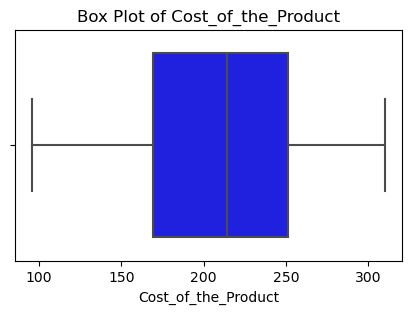

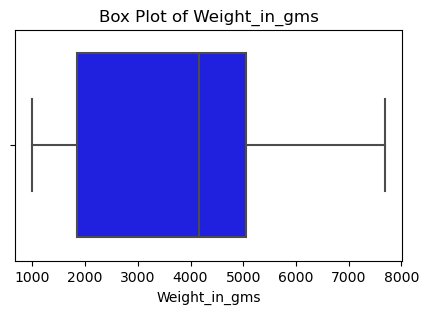

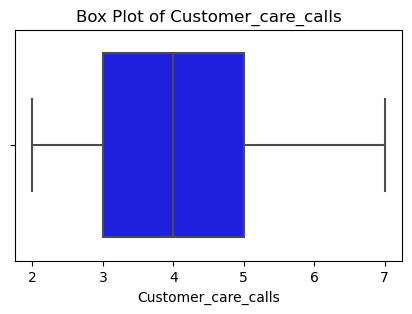

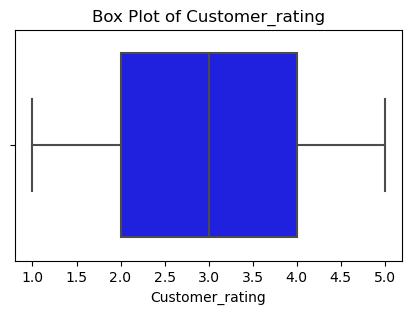

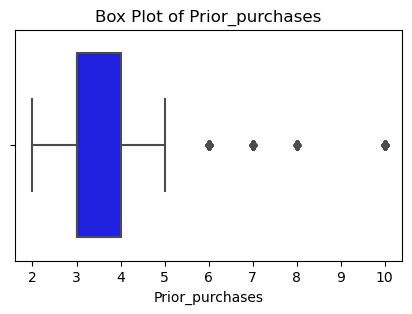

In [105]:
# We'll use box plots to understand the distribution of numerical columns and identify outliers.

numerical_cols = ['Cost_of_the_Product', 'Weight_in_gms', 'Customer_care_calls', 'Customer_rating', 'Prior_purchases']

for col in numerical_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=data[col], color='blue')
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()
    

In [ ]:
# Impression:

# # Customer_care_calls: 
# # # Expected Outcome: The box plot shows that most customers make a moderate number of customer care calls 
# # (e.g., around 3 to 5 calls, based on the sample).

# Customer_rating: 
# Expected Outcome: The ratings seem to range from 2 to 4. The box plot shows that most ratings are 
# concentrated around a middle value, with fewer ratings at the extremes.

# Cost_of_the_Product
# Expected Outcome: The cost of the products in our sample ranges from 176 to 250. 
# The box plot shows how tightly clustered these values are around the median, with a possible range of costs.

# Prior_purchases
# Expected Outcome: With prior purchases ranging from 2 to 4 in your sample, 
# the box plot shows a narrow box indicating that most customers have made a similar number of purchases.
# Outliers: Customers with significantly fewer or more purchases appear as outliers.

# Weight_in_gms
# Expected Outcome: The weights range from 1,177 to 5,274 grams.
# The box plot shows a wide distribution of weights, especially if the products vary significantly in size.


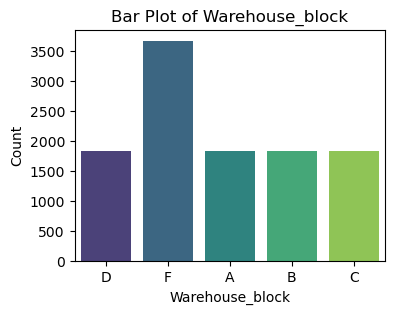

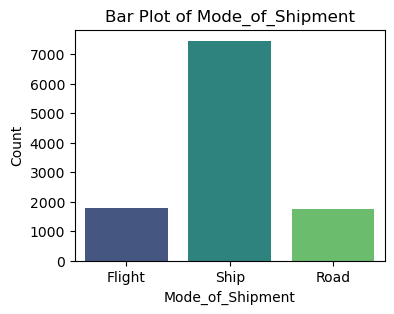

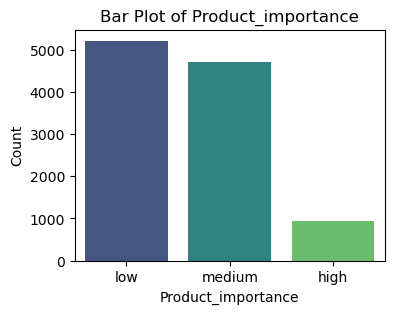

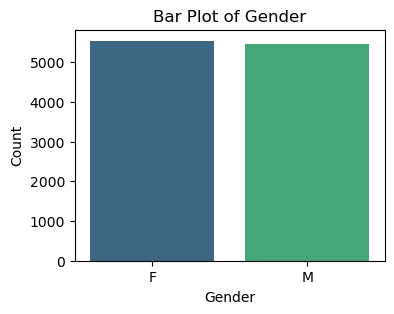

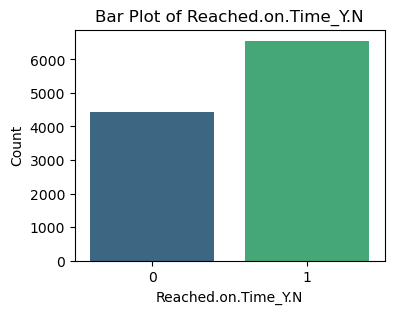

In [107]:
# Now we'll use bar plots to understand 
# the distribution of categorical columns and check for class imbalance in the target variable.

categorical_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Reached.on.Time_Y.N']

for col in categorical_cols:
    plt.figure(figsize=(4, 3))
    sns.countplot(x=data[col], palette='viridis')
    plt.title(f'Bar Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()
    

In [ ]:
# Impression:

# Warehouse_block
# The bar plot shows how many shipments originate from each warehouse block (A, B, C, D, F).
# It shows that blocks F has the highest counts, this warehouse is handling most number of shipments than others.

# Mode_of_Shipment
# The bar plot is displaying the frequency of each mode of shipment (Flight, Ship, Road).
# It shows that "Ship" is the most frequent mode, it indicates a preference for faster delivery, possibly at moderate cost.

# Product_importance
# The bar plot shows the distribution of product importance levels (low, medium, high).
# Since the plot shows most products are labeled as "low" importance, it suggests that the majority of shipments are not critical.
# Fewer "high" importance products might mean that high-priority items are rare and possibly handled with more care.

# Gender
# The bar plot depicts the gender distribution (Male, Female) in the dataset.
# Since the bar plot shows that there is a fairly even split between Male and Female, gender 
# likely doesn't play a significant role in the shipment process.

# Reached.on.Time_Y.N 
# The bar plot shows the counts of shipments that arrived on time (1) versus those that did not (0).
# Since the plot shows a much higher count for 1 compared to 0, 
# it indicates that most shipments arrive on time, which is positive for business but may lead to class imbalance in the model.


In [109]:
# Now inspecting the dataset for missing values.
# First we will check the null values

missing_values = data.isnull().sum()
print(missing_values)


ID                       0
Warehouse_block          0
Mode_of_Shipment         0
Customer_care_calls      0
Customer_rating          0
Cost_of_the_Product     98
Prior_purchases          0
Product_importance     154
Gender                   0
Discount_offered         0
Weight_in_gms          139
Reached.on.Time_Y.N      0
dtype: int64


In [111]:
# # categorical data implant
# # By selecting the [0] index, we pick the first mode in case there are multiple modes.
# # Why the First Mode?
# # In most practical scenarios, using the first mode is sufficient because:
# Data Consistency: The first mode is the most frequent value, representing the most common category.
# Simplicity: It keeps the imputation process straightforward without introducing unnecessary complexity.

data['Product_importance'].fillna(data['Product_importance'].mode()[0], inplace=True)


In [113]:
## numerical data implant:
# Since the data is normally distributed and has few missing values, we will use mean for both the columns.

data['Cost_of_the_Product'].fillna(data['Cost_of_the_Product'].mean(), inplace=True)
data['Weight_in_gms'].fillna(data['Weight_in_gms'].mean(), inplace=True)


In [115]:
# Post imputing the data, we again check to verify the data imputation.

missing_values = data.isnull().sum()
print(missing_values)


ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64


In [117]:
# now we will convert the categorical data into numerical data to feed to the model
# We are using Label Encoder for the conversion as it converts categorical data into numerical data
# by assigning a unique integer to each category. 
# This is especially useful for machine learning algorithms that require numerical input

encoder = LabelEncoder()
data['Product_importance'] = encoder.fit_transform(data['Product_importance'])
data['Warehouse_block'] = encoder.fit_transform(data['Warehouse_block'])
data['Mode_of_Shipment'] = encoder.fit_transform(data['Mode_of_Shipment'])
data['Gender'] = encoder.fit_transform(data['Gender'])
print(data.head())


   ID  Warehouse_block  Mode_of_Shipment  Customer_care_calls  \
0   1                3                 0                    4   
1   2                4                 0                    4   
2   3                0                 0                    2   
3   4                1                 0                    3   
4   5                2                 0                    2   

   Customer_rating  Cost_of_the_Product  Prior_purchases  Product_importance  \
0                2                177.0                3                   1   
1                5                216.0                2                   1   
2                2                183.0                4                   1   
3                3                176.0                4                   2   
4                2                184.0                3                   2   

   Gender  Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0       0                44         1233.0                    

In [119]:
# Define features and target variable
# Features (X) are all columns except the target variable Reached.on.Time_Y.N.
# The target variable (y) is the column that indicates whether the shipment arrived on time.

X = data.drop(columns = ['Reached.on.Time_Y.N'])
y = data['Reached.on.Time_Y.N']


In [121]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [123]:
# Initialize the XGBoost model with a specified evaluation metric.
# logarithmic loss" or "log loss," evaluation metric is used for classification problems, 
# particularly when the model outputs probabilities.

model = xgb.XGBClassifier(eval_metric='logloss')


In [125]:
# Now taking a dictionary parameter grid allows us to systematically explore different combinations of these
# hyperparameters to find the set that gives the best performance on our validated data.

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.1],
    'min_child_weight': [1]
}


In [127]:
# We are using RandomizedSearchCV for faster hyperparameter tuning
# RandomizedSearchCV samples a fixed number of parameter settings from the specified param_grid

randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                       n_iter=4, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
randomized_search.fit(X_train, y_train)
print(f'Best parameters: {randomized_search.best_params_}')


Best parameters: {'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1}


In [129]:
# We are using the best model for predictions

best_model = randomized_search.best_estimator_
y_pred = best_model.predict(X_test)

In [131]:
# We then calculate evaluation metrics
# Assuming '1' indicates 'on time'
# Print evaluation results


accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label=1)  
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print()

# Print the Recall value
print(f'Recall: {recall:.2f}')  
print()

print('Confusion Matrix:')
print(conf_matrix)
print()

print('Classification Report:')
print(class_report)

Accuracy: 0.69

Recall: 0.49

Confusion Matrix:
[[890   5]
 [668 637]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.99      0.73       895
           1       0.99      0.49      0.65      1305

    accuracy                           0.69      2200
   macro avg       0.78      0.74      0.69      2200
weighted avg       0.82      0.69      0.68      2200



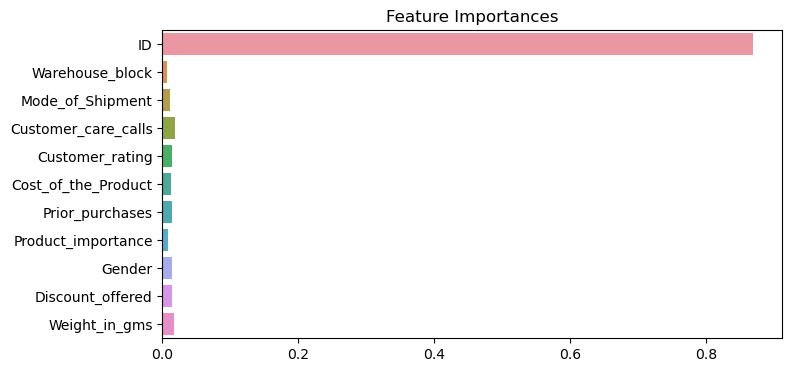

In [133]:
# Finally, we check the Feature Importance which shows which features were used to train the model.

feature_importances = best_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8, 4))
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importances')
plt.show()


In [140]:
# Impressions:
# Features like "Customer_care_calls," "Cost_of_the_Product," or "Weight_in_gms" appear as the most important,
# as it indicates that these factors play a significant role in determining whether a shipment arrives on time.
# The "Warehouse_block" or "Mode_of_Shipment" is prominently featured and suggests that certain shipping methods 
# or locations are associated with delays
# High importance of features related to customer care or product characteristics 
# indicates that improving customer service or optimizing product handling can lead to better on-time performance.
# Features with lower importance suggests that they have less impact on predicting shipment timeliness.